# Libraries

In [94]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import glob, os


# Import

In [95]:
'''Connects to Google Drive to load in data'''

'''
# Connect to and mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Find the dataset in google drive and assign path to variable called 'Match'
file_paths = glob.glob('/content/drive/MyDrive/**/cleanedprices.pkl', recursive=True)
print("Found paths:", file_paths)

prices = pd.read_pickle(file_paths[0])
prices['GasolinePrices_Adjusted'] = prices['GasolinePrices_Adjusted'].round(2)
prices['DieselPrices_Adjusted'] = prices['DieselPrices_Adjusted'].round(2)
'''


'''import and remove extra columns'''
prices = pd.read_pickle("../FuelPrices/cleanedprices.pkl")
prices['GasolinePrices_Adjusted'] = prices['GasolinePrices_Adjusted'].round(2)
prices['DieselPrices_Adjusted'] = prices['DieselPrices_Adjusted'].round(2)


In [96]:
''' Verify Prices Data'''

prices.info()
print("\n", prices)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Date                     324 non-null    datetime64[ns]
 1   GasolinePrices           324 non-null    float64       
 2   DieselPrices             324 non-null    float64       
 3   GasolinePrices_Adjusted  324 non-null    float64       
 4   DieselPrices_Adjusted    324 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 12.8 KB

           Date  GasolinePrices  DieselPrices  GasolinePrices_Adjusted  \
0   1995-01-01           1.130         1.098                     2.10   
1   1995-02-01           1.120         1.088                     2.07   
2   1995-03-01           1.119         1.088                     2.06   
3   1995-04-01           1.157         1.104                     2.12   
4   1995-05-01           1.225         1.1

# Correlation

In [97]:
prices[['GasolinePrices_Adjusted', 'DieselPrices_Adjusted']].corr()

,GasolinePrices_Adjusted,DieselPrices_Adjusted
GasolinePrices_Adjusted,1.00000,0.97277
DieselPrices_Adjusted,0.97277,1.00000


# Visualizations

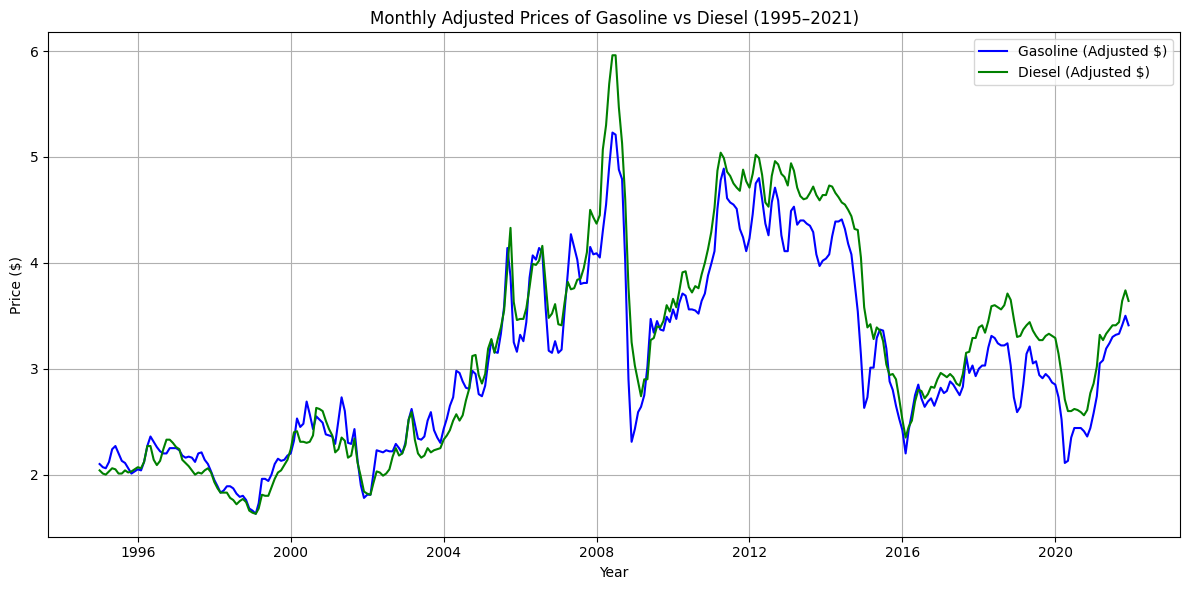

In [98]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(prices['Date'], prices['GasolinePrices_Adjusted'], label='Gasoline (Adjusted $)', color='blue')
plt.plot(prices['Date'], prices['DieselPrices_Adjusted'], label='Diesel (Adjusted $)', color='green')
plt.title('Monthly Adjusted Prices of Gasoline vs Diesel (1995–2021)')
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

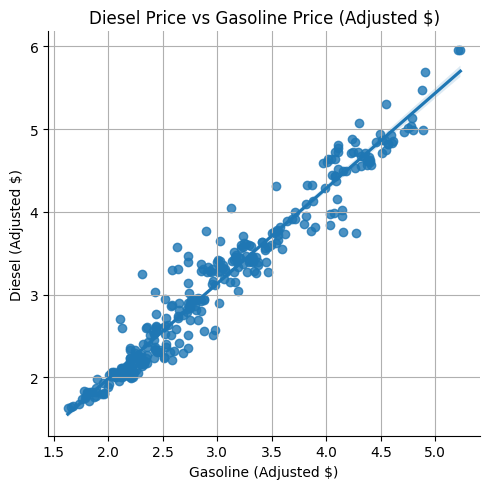

In [99]:
import seaborn as sns

sns.lmplot(x='GasolinePrices_Adjusted', y='DieselPrices_Adjusted', data=prices)
plt.title('Diesel Price vs Gasoline Price (Adjusted $)')
plt.xlabel('Gasoline (Adjusted $)')
plt.ylabel('Diesel (Adjusted $)')
plt.grid(True)
plt.tight_layout()
plt.show()

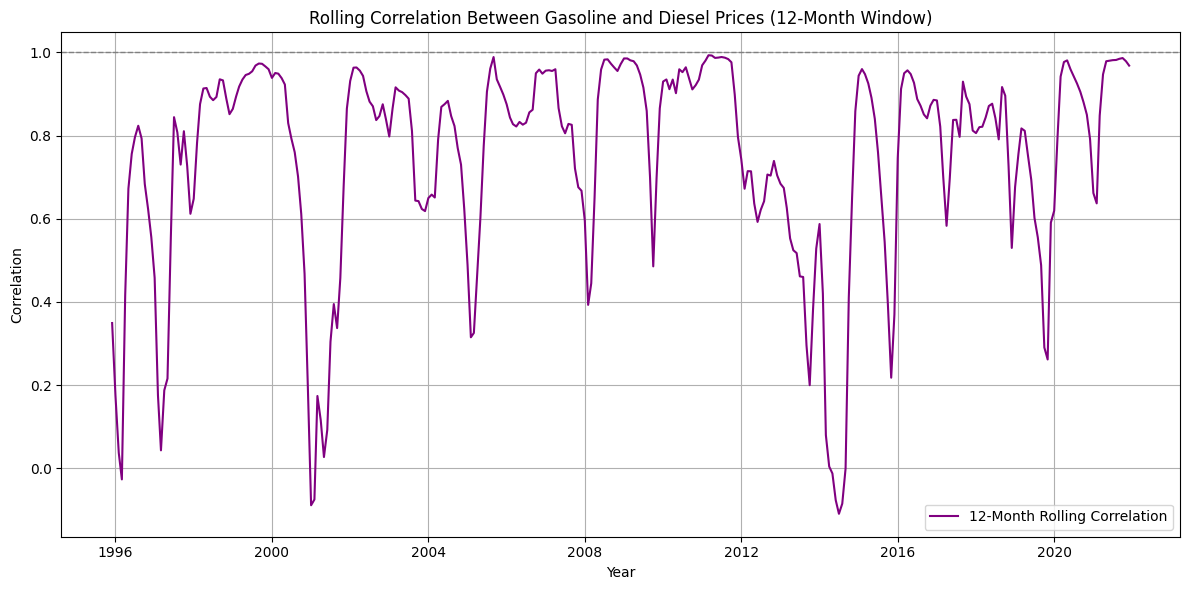

In [100]:
prices.set_index('Date', inplace=True)
rolling_corr = prices['GasolinePrices_Adjusted'].rolling(12).corr(prices['DieselPrices_Adjusted'])

plt.figure(figsize=(12, 6))
plt.plot(rolling_corr, label='12-Month Rolling Correlation', color='purple')
plt.axhline(y=1, color='gray', linestyle='--', linewidth=1)
plt.title('Rolling Correlation Between Gasoline and Diesel Prices (12-Month Window)')
plt.xlabel('Year')
plt.ylabel('Correlation')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

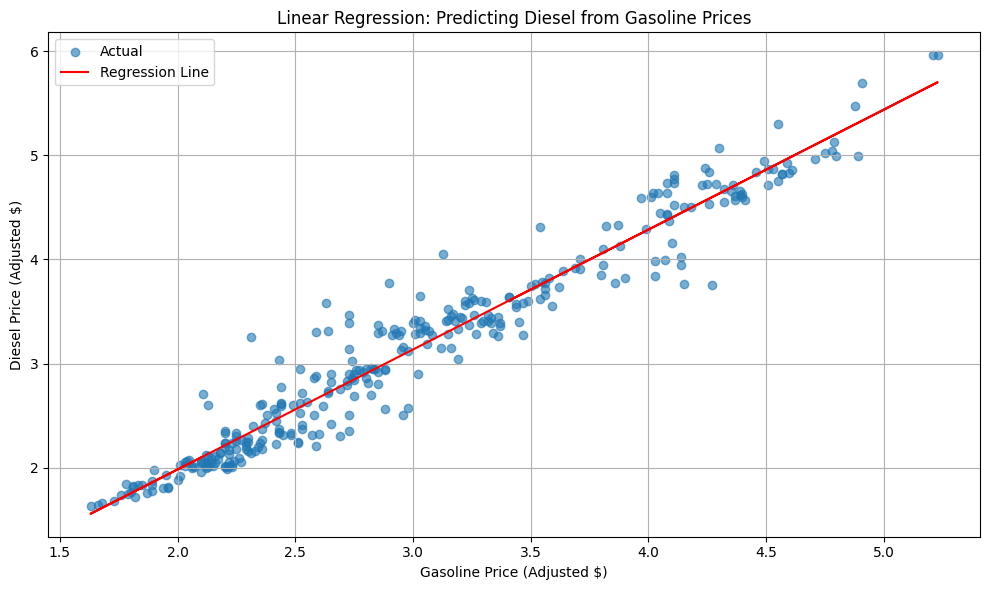

R² Score: 0.9462818546347781
Slope (beta): 1.1511396773586
Intercept: -0.31944715425702785


In [101]:
from sklearn.linear_model import LinearRegression
import numpy as np

X = prices['GasolinePrices_Adjusted'].values.reshape(-1, 1)
y = prices['DieselPrices_Adjusted'].values
model = LinearRegression()
model.fit(X, y)

# Predictions
y_pred = model.predict(X)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(X, y, label='Actual', alpha=0.6)
plt.plot(X, y_pred, color='red', label='Regression Line')
plt.title('Linear Regression: Predicting Diesel from Gasoline Prices')
plt.xlabel('Gasoline Price (Adjusted $)')
plt.ylabel('Diesel Price (Adjusted $)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Metrics
print("R² Score:", model.score(X, y))
print("Slope (beta):", model.coef_[0])
print("Intercept:", model.intercept_)

In [102]:
# Step 1: Calculate monthly percentage change for both
prices['Gasoline_PctChange'] = prices['GasolinePrices_Adjusted'].pct_change()
prices['Diesel_PctChange'] = prices['DieselPrices_Adjusted'].pct_change()

# Step 2: Calculate the absolute difference between their % changes
prices['Pct_Diff'] = (prices['Gasoline_PctChange'] - prices['Diesel_PctChange']).abs()

# Step 3: Check where the difference is less than or equal to 0.05 (i.e. within 5%)
within_5pct = prices['Pct_Diff'] <= 0.05

# Step 4: Calculate the percentage of months where this condition is True
percent_within_5pct = within_5pct.sum() / within_5pct.count() * 100

print(f"Percentage of months where Gasoline and Diesel moved within ±5% of each other: {percent_within_5pct:.2f}%")

Percentage of months where Gasoline and Diesel moved within ±5% of each other: 87.04%


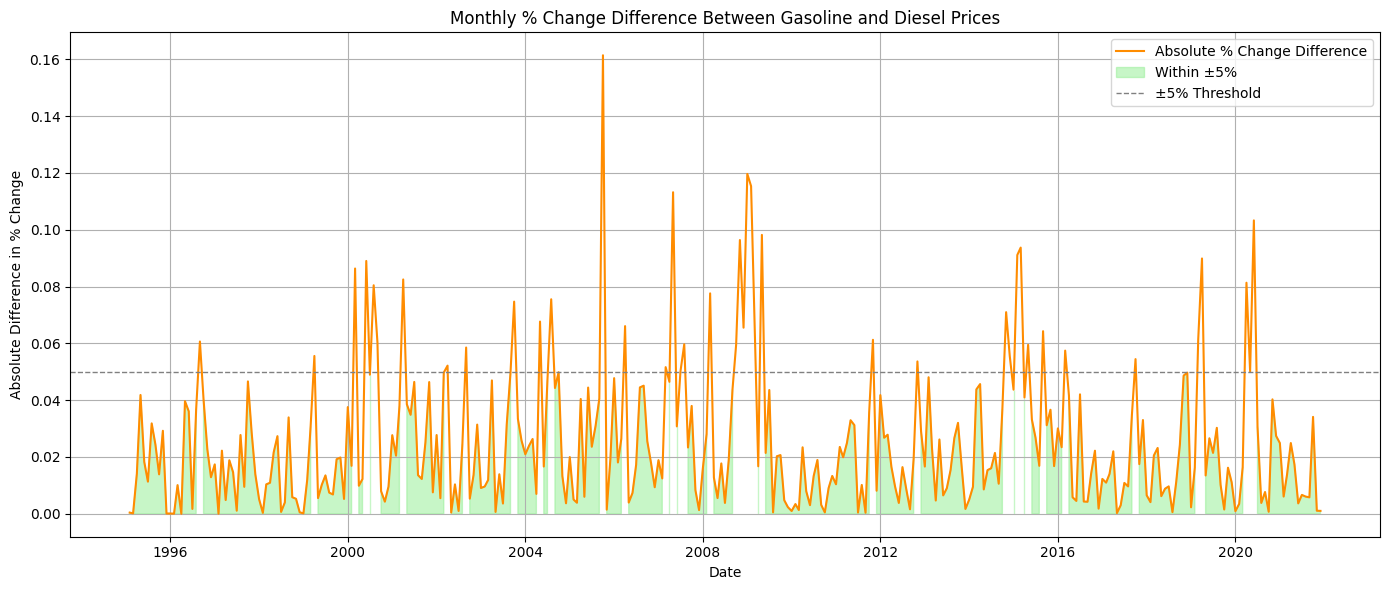

In [103]:
# Ensure previous calculations are done
prices['Gasoline_PctChange'] = prices['GasolinePrices_Adjusted'].pct_change()
prices['Diesel_PctChange'] = prices['DieselPrices_Adjusted'].pct_change()
prices['Pct_Diff'] = (prices['Gasoline_PctChange'] - prices['Diesel_PctChange']).abs()
prices['Within_5pct'] = prices['Pct_Diff'] <= 0.05

# Plot
plt.figure(figsize=(14, 6))

# Plot the percentage difference
plt.plot(prices.index, prices['Pct_Diff'], label='Absolute % Change Difference', color='darkorange')

# Highlight areas where it's within 5%
plt.fill_between(prices.index, 0, prices['Pct_Diff'],
                 where=prices['Within_5pct'],
                 color='lightgreen', alpha=0.5, label='Within ±5%')

# Threshold line at 0.05
plt.axhline(y=0.05, color='gray', linestyle='--', linewidth=1, label='±5% Threshold')

# Labels and Title
plt.title('Monthly % Change Difference Between Gasoline and Diesel Prices')
plt.xlabel('Date')
plt.ylabel('Absolute Difference in % Change')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

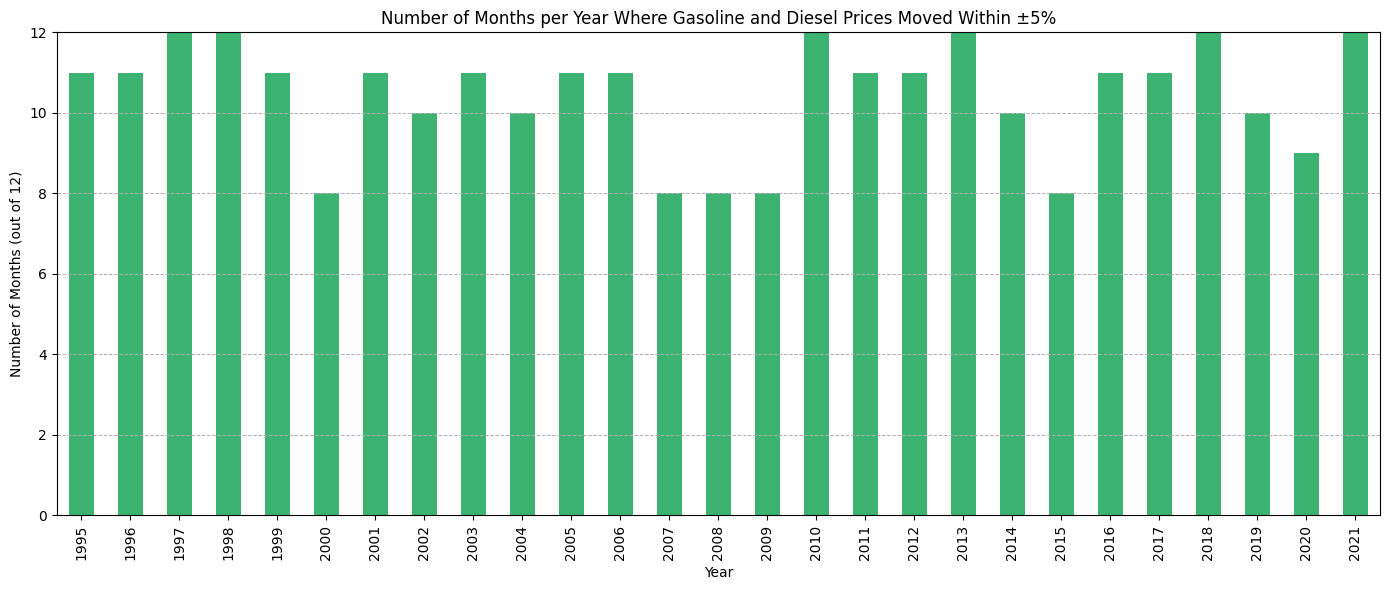

In [104]:
# First, make sure we have the column already
prices['Year'] = prices.index.year

# Count how many months per year had similar % changes
monthly_agreement_counts = prices.groupby('Year')['Within_5pct'].sum()

# Plot bar chart
plt.figure(figsize=(14, 6))
monthly_agreement_counts.plot(kind='bar', color='mediumseagreen')

# Titles and labels
plt.title('Number of Months per Year Where Gasoline and Diesel Prices Moved Within ±5%')
plt.xlabel('Year')
plt.ylabel('Number of Months (out of 12)')
plt.ylim(0, 12)  # Max is 12 months per year
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()

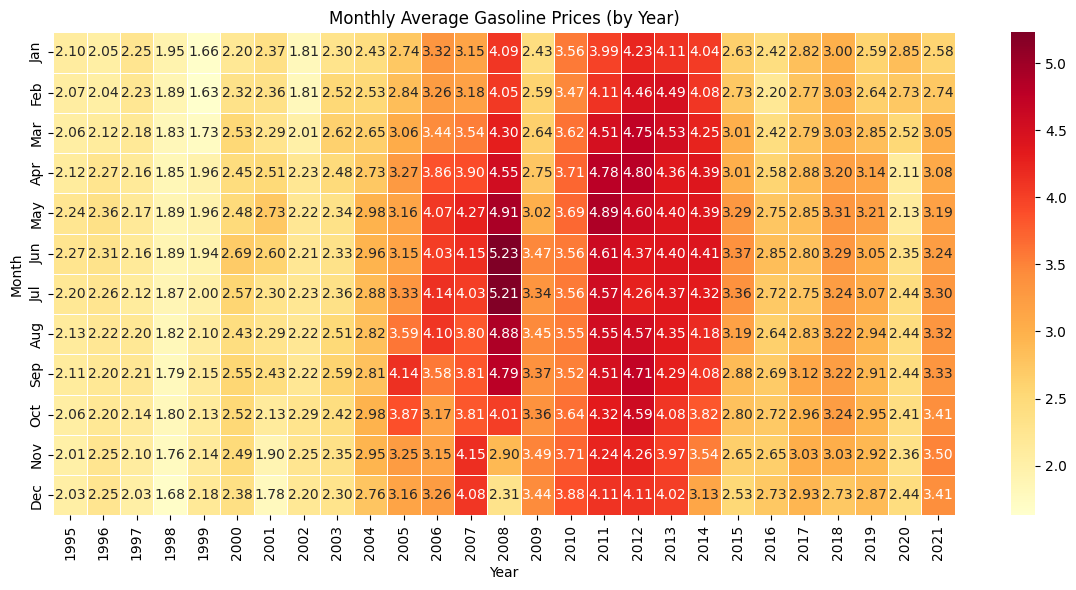

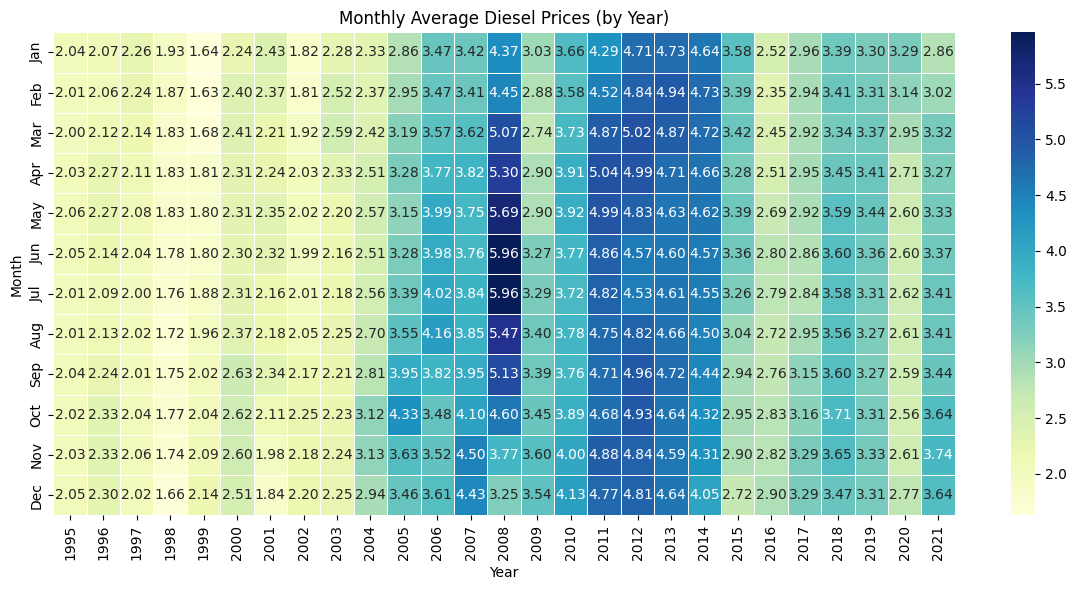

In [105]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype

# Reset index and ensure Date column is datetime
prices.reset_index(inplace=True)
prices['Date'] = pd.to_datetime(prices['Date'])

# Extract year and month
prices['Year'] = prices['Date'].dt.year
prices['Month'] = prices['Date'].dt.strftime('%b')  # Month abbreviation (Jan, Feb, etc.)
prices['Month_num'] = prices['Date'].dt.month       # For sorting (used below once)

# Group by Year, Month
monthly_avg = prices.groupby(['Year', 'Month', 'Month_num']).agg({
    'GasolinePrices_Adjusted': 'mean',
    'DieselPrices_Adjusted': 'mean'
}).reset_index()

# Define month order and apply it
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_cat = CategoricalDtype(categories=month_order, ordered=True)
monthly_avg['Month'] = monthly_avg['Month'].astype(month_cat)

# Sort by month (chronologically)
monthly_avg = monthly_avg.sort_values(by='Month')

# Create pivot tables for heatmaps
gas_pivot = monthly_avg.pivot(index='Month', columns='Year', values='GasolinePrices_Adjusted')
diesel_pivot = monthly_avg.pivot(index='Month', columns='Year', values='DieselPrices_Adjusted')

# Plot Gasoline Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(gas_pivot, cmap='YlOrRd', annot=True, fmt='.2f', linewidths=0.5)
plt.title('Monthly Average Gasoline Prices (by Year)')
plt.ylabel('Month')
plt.xlabel('Year')
plt.tight_layout()
plt.show()

# Plot Diesel Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(diesel_pivot, cmap='YlGnBu', annot=True, fmt='.2f', linewidths=0.5)
plt.title('Monthly Average Diesel Prices (by Year)')
plt.ylabel('Month')
plt.xlabel('Year')
plt.tight_layout()
plt.show()

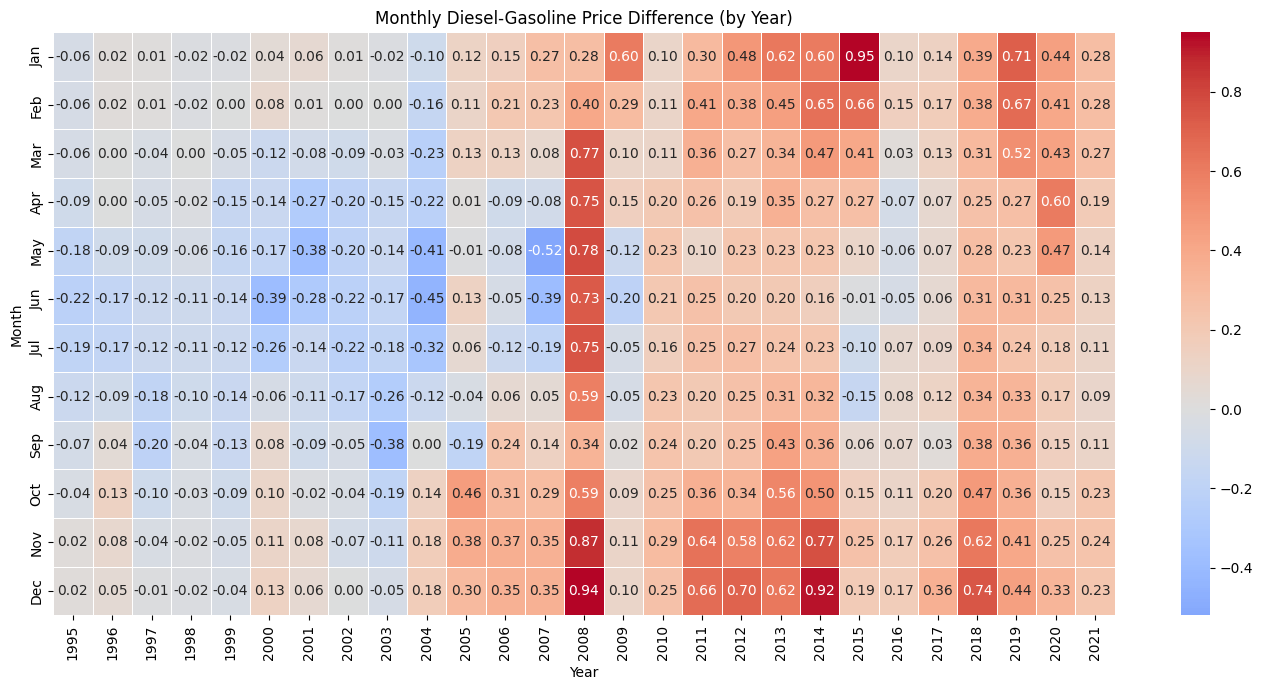

In [106]:
# Add a difference column
monthly_avg['Diff'] = monthly_avg['DieselPrices_Adjusted'] - monthly_avg['GasolinePrices_Adjusted']

# Pivot for difference heatmap
diff_pivot = monthly_avg.pivot(index='Month', columns='Year', values='Diff')

# Plot Difference Heatmap
plt.figure(figsize=(14, 7))
sns.heatmap(diff_pivot, cmap='coolwarm', center=0, annot=True, fmt='.2f', linewidths=0.5)
plt.title('Monthly Diesel-Gasoline Price Difference (by Year)')
plt.ylabel('Month')
plt.xlabel('Year')
plt.tight_layout()
plt.show()

Same direction: 224 months
Opposite direction: 100 months
Percentage agreement: 69.14%


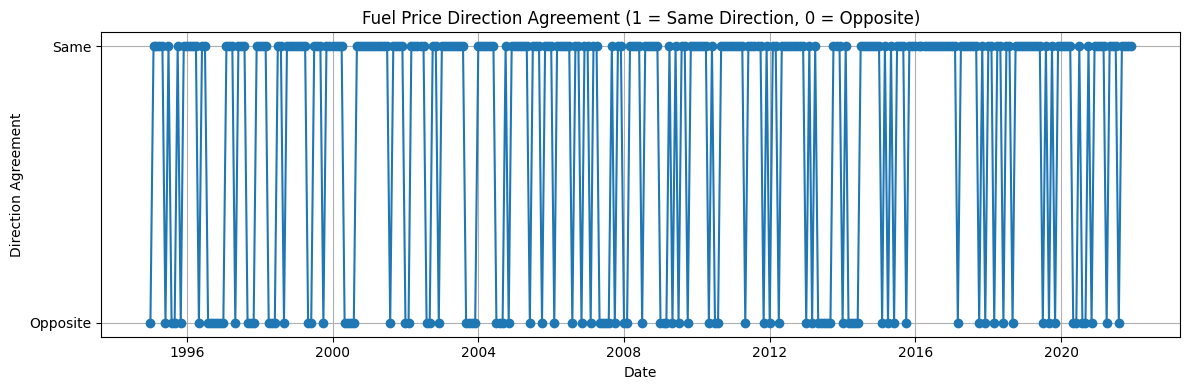

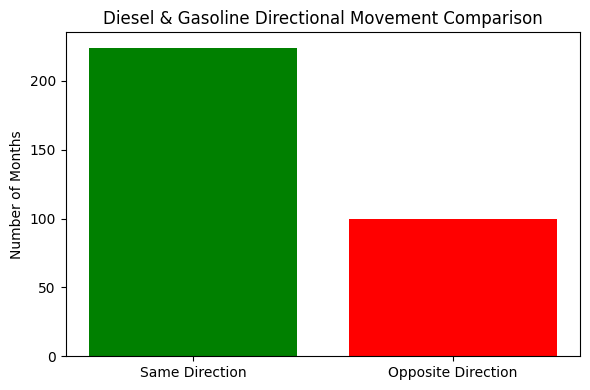

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Sort by date
prices = prices.sort_values(by='Date')

# Step 2: Calculate month-over-month deltas
prices['Gasoline_Change'] = prices['GasolinePrices_Adjusted'].diff()
prices['Diesel_Change'] = prices['DieselPrices_Adjusted'].diff()

# Step 3: Directional change (+1, -1, or 0)
prices['Gasoline_Dir'] = np.sign(prices['Gasoline_Change'])
prices['Diesel_Dir'] = np.sign(prices['Diesel_Change'])

# Step 4: Determine agreement (1 = same direction, 0 = opposite)
prices['Same_Direction'] = (prices['Gasoline_Dir'] == prices['Diesel_Dir']).astype(int)

# Drop the first row (no previous month to compare)
prices_clean = prices.dropna(subset=['Same_Direction'])

# Step 5: Count total and agreement
total_months = len(prices_clean)
same_direction_count = prices_clean['Same_Direction'].sum()
opposite_direction_count = total_months - same_direction_count
percent_same = same_direction_count / total_months * 100

print(f"Same direction: {same_direction_count} months")
print(f"Opposite direction: {opposite_direction_count} months")
print(f"Percentage agreement: {percent_same:.2f}%")

# Optional: Monthly timeline plot
plt.figure(figsize=(12, 4))
plt.plot(prices_clean['Date'], prices_clean['Same_Direction'], marker='o', linestyle='-')
plt.title('Fuel Price Direction Agreement (1 = Same Direction, 0 = Opposite)')
plt.xlabel('Date')
plt.ylabel('Direction Agreement')
plt.yticks([0, 1], ['Opposite', 'Same'])
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: Stacked bar chart summary
plt.figure(figsize=(6, 4))
plt.bar(['Same Direction', 'Opposite Direction'], [same_direction_count, opposite_direction_count], color=['green', 'red'])
plt.title('Diesel & Gasoline Directional Movement Comparison')
plt.ylabel('Number of Months')
plt.tight_layout()
plt.show()